In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
sys.path.append('/home/monte.flora/python_packages/scikit-explain/tutorial_notebooks')
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')
sys.path.append('/work/mflora/ROAD_SURFACE')
import skexplain
import shap
import plotting_config
from skexplain.plot.base_plotting import PlotStructure
from skexplain.common.contrib_utils import get_indices_based_on_performance
import numpy as np

from load_models_and_data import load_model_and_data
from probsr_config import FIGURE_MAPPINGS, UNITS
from display_names import to_readable_names, get_units

In [2]:
hazard = 'road_surface'
estimators, X, y = load_model_and_data(hazard, test=True)

In [3]:
feature_names = X.columns

display_feature_names = {f : to_readable_names(f) for f in feature_names}
display_units = {f : get_units(f) for f in feature_names}

display_feature_names = {**display_feature_names, **FIGURE_MAPPINGS}
display_units = {**display_units, **UNITS }

In [4]:
inds_dict = get_indices_based_on_performance(estimators[1], X, y, estimator_output='probability', n_samples=25)

In [5]:
inds_dict.keys()

dict_keys(['Best Hits', 'Worst Misses', 'Worst False Alarms', 'Best Corr. Negatives'])

In [8]:
for key in ['Best Corr. Negatives']:
    single_example = X.iloc[inds_dict[key]]
    explainer = skexplain.ExplainToolkit(estimators, 
                                    X=single_example, 
                                   )

    ti_ds = explainer.local_contributions(method='tree_interpreter')
    shap_ds = explainer.local_contributions(method='shap', 
                                        shap_kwargs={'masker' : 
                                          shap.maskers.Partition(X, max_samples=200, clustering="correlation"), 
                                             'algorithm' : 'auto'}
                                       )
    lime_ds = explainer.local_contributions(method='lime', lime_kws={'training_data': X.values})
    
    ti_ds.to_pickle(f"ti_results_{key.replace(' ', '_')}.pkl")
    shap_ds.to_pickle(f"shap_ds_results_{key.replace(' ', '_')}.pkl")
    lime_ds.to_pickle(f"lime_results_{key.replace(' ', '_')}.pkl")

Exact explainer: 26it [06:45, 16.21s/it]                                                                                                                                                                                             


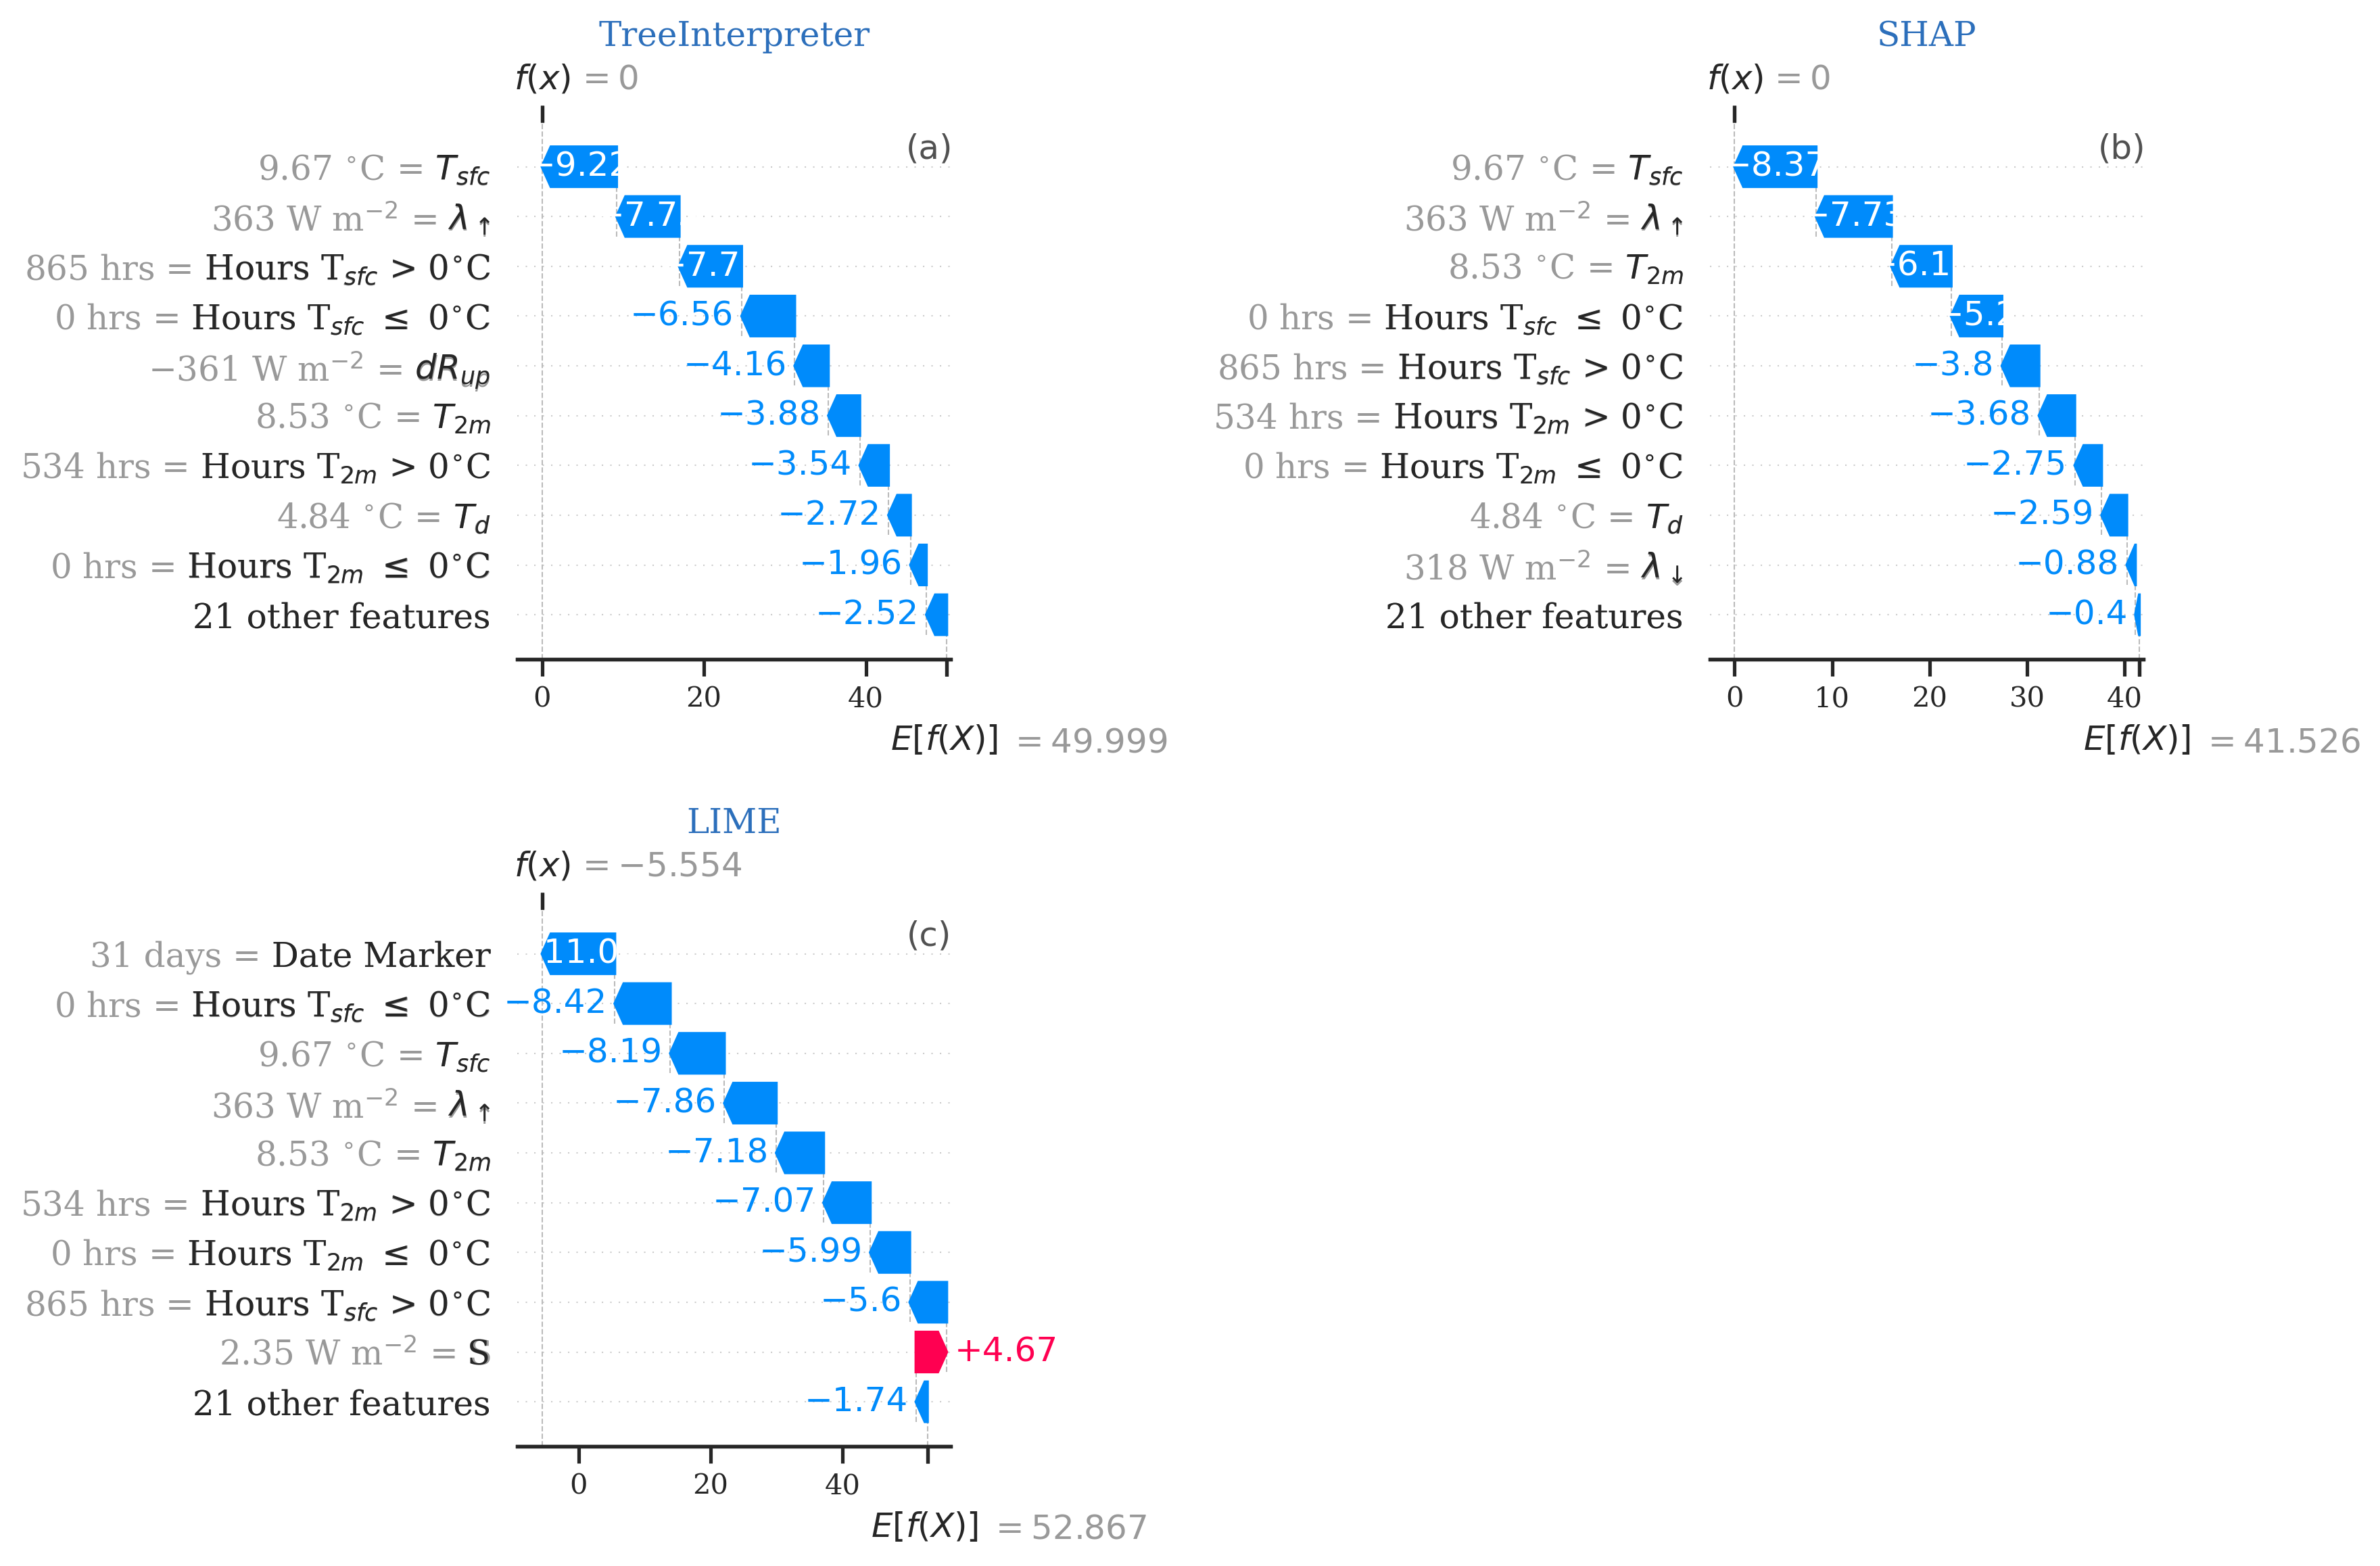

In [9]:
datasets = [ti_ds, shap_ds, lime_ds]
titles = ['TreeInterpreter', 'SHAP', 'LIME']

#datasets = [shap_ds, lime_ds]
#titles = [ 'SHAP', 'LIME']

plotter= PlotStructure(BASE_FONT_SIZE = 16, set_seaborn=False)
fig, axes = plotter.create_subplots(n_panels=len(datasets), n_columns=2, figsize=(12,8), dpi=300, 
                                      wspace=0.4, hspace=0.05)

for ax, results, title in zip(axes.flat, datasets, titles):
     ax.set_title(title, color='xkcd:medium blue')   
     explainer.plot_contributions(
                               contrib=results,
                               display_feature_names=display_feature_names,
                               display_units = display_units,
                               ax=ax, 
                                )
    
plotter.add_alphabet_label(3, axes, pos=(0.95, 0.95), alphabet_fontsize=12)    
fig.tight_layout()